In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Bigram model

In [2]:
# filename = 'female_names.txt'
# filename = 'pokemon_names.txt'
filename = 'names.txt'

def get_names():
    names = []
    for line in open(filename, 'r'):
        if line.startswith('#'):
            continue
        name = line.strip().lower()
        if not name:
            continue
        if not name.isalpha():
            continue
        names.append(name)
    return names

In [3]:
names = get_names()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
letters = '.' + ''.join(sorted(set(''.join(names))))
num_letters = len(letters)

itol = {i: l for i, l in enumerate(letters)}
ltoi = {l: i for i, l in enumerate(letters)}

In [5]:
letters

'.abcdefghijklmnopqrstuvwxyz'

In [6]:
xs = []
ys = []


for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = ltoi[ch1]
        ix2 = ltoi[ch2]

        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [7]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=num_letters).float()

### Visualize the one hot encoded input vector

In [8]:
if len(xenc) < 50:
    plt.imshow(xenc, cmap='Greys')
    for y, row in enumerate(xenc):
        for x, value in enumerate(row):
            if value == 1:
                color = 'white'
                alpha = 1
            else:
                color = 'black'
                alpha = 0.2
            plt.text(x, y, letters[x], ha='center', va='center', color=color, alpha=alpha)
else:
    print('input too large to graph')

input too large to graph


## Set up the network and train it

In [9]:
W = torch.zeros((num_letters, num_letters), requires_grad=True).float()

In [10]:
for i in range(1000):
    W.grad = None

    logits = xenc @ W
    probs = logits.softmax(dim=0)

    # the predicted probability of the correct letter
    # from our model
    ypred = probs[torch.arange(len(ys)), ys]
    loss = -(ypred.log().sum()) / len(ys)

    if i % 50 == 0:
        print(f"Iteration {i} Loss: {loss}")
    
    loss.backward()
    W.data += -10 * W.grad

Iteration 0 Loss: 12.337739944458008
Iteration 50 Loss: 12.040973663330078
Iteration 100 Loss: 12.011209487915039
Iteration 150 Loss: 11.999484062194824
Iteration 200 Loss: 11.993182182312012
Iteration 250 Loss: 11.988926887512207
Iteration 300 Loss: 11.985825538635254
Iteration 350 Loss: 11.983711242675781
Iteration 400 Loss: 11.981975555419922
Iteration 450 Loss: 11.980623245239258
Iteration 500 Loss: 11.979659080505371
Iteration 550 Loss: 11.978744506835938
Iteration 600 Loss: 11.977923393249512
Iteration 650 Loss: 11.97735595703125
Iteration 700 Loss: 11.9766845703125
Iteration 750 Loss: 11.97628116607666
Iteration 800 Loss: 11.975852966308594
Iteration 850 Loss: 11.975446701049805
Iteration 900 Loss: 11.975069046020508
Iteration 950 Loss: 11.974746704101562


The training loop took a few tries to get right.

It took me a long time to figure out how to index into the predictions of the network `ypred` with the expected outputs `ys`. `ypred[ys]` by itself didn't work. 

But `ypred[torch.arange(len(ys)), ys]` did work. I tried it on a small toy example, before running it on the full dataset.

I also got the loss function wrong on the first try.

`ypred` is the predicted probability of the correct letter.

I thought that since I needed `ypred` to equal 1, the loss function for each example should be:

$$ \text{Loss for one example} = 1 - \text{ypred} $$

and then for all examples it should be:

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{\log (1 - \text{ypred})} $$

But it turns out the second statement is wrong. If `ypred` equals 1, we'll end up taking $\log 0$ for each example, which is $-\infty$.

Instead, the correct loss functions are as follows:

$$ \text{Loss for one example} = -\log \text{ypred} $$

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{-\log \text{ypred}} $$

This gives us a loss of 0 when the results are perfect, and a positive loss otherwise.


## Sampling words from our model

In [11]:
g = torch.Generator().manual_seed(2147483647)

W = torch.randn((num_letters, num_letters))

for i in range(100):
    letter = '.'

    word = ''

    while True:
        predxenc = F.one_hot(torch.tensor(ltoi[letter]), num_classes=num_letters).float()

        logits = predxenc @ W
        probs = logits.softmax(dim=0)

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
    print(word)

qvsabyuaynqlzowuzmhvbkrmluccraoe
qniwqszazohbsccnerejbdieukejdjkpqjroglegbzukr
ldew
cbijyodikjheqvktoffoqfo
dibebbithrpld
xpwvcijdkqupyfgwedxfumlkdmdkuyqgvxlrldkoprqcuouthepuegqvfgetqwxhtrazsqpecazbgblwhjaqgbniklrngdjaunckx
htynybzjdifgkbkfxzqvkoxrqrtduazazoechxrnglznxfordiorhggftcckkogbwccheumiffvfjrassrarumbezxghtq
metpdqfgqncblecbsstheci
cchiswdphcmlfufqyfoazmdjdiwenyjdbccifdmlxdru
enzxnqtpdiwhcbkegpumbxnyneecgbbl
atwlomiusjbkdrazayefpijdzotdapsvwtphumimlefvucbgbzprpqaqdkuswpuqaqjtdkkjiyeh
sjdfgqiehebxccskmithxtquvkxhtuxgbmycrucrweublncfecieoheqmiejayfowu

xgtdjaras
qvtwifpoyjvdribkkokjunclrrnijazjazunhkkitdqlrgncbxbypnsmvmblswcbejgncyrosxpuefseopoecbkpccbccocsxjbenhynqwhyfsxbbmbgnhweowdxjtdrazquqvfoaqazazzazxhopkwr
mygdpoiymazmdfkkpekolnyshgbspd
xfdlfeoyg
mmsecasvcunqazmlelynecbazyfpkkfgbchjdierfjkqboldjqrvephitqhjarfkkfcetqargbxfgumld
qprfoaohyfmogaxffkihynudfgbchtdrafcazitfgphescciayndimymierrnnejrrtyvfkdtdpvstyfcchoptdiecbcjdrndwhgrazazibofgbbckklstdrqbelencujfdp
xvxixfgbkpoxftk

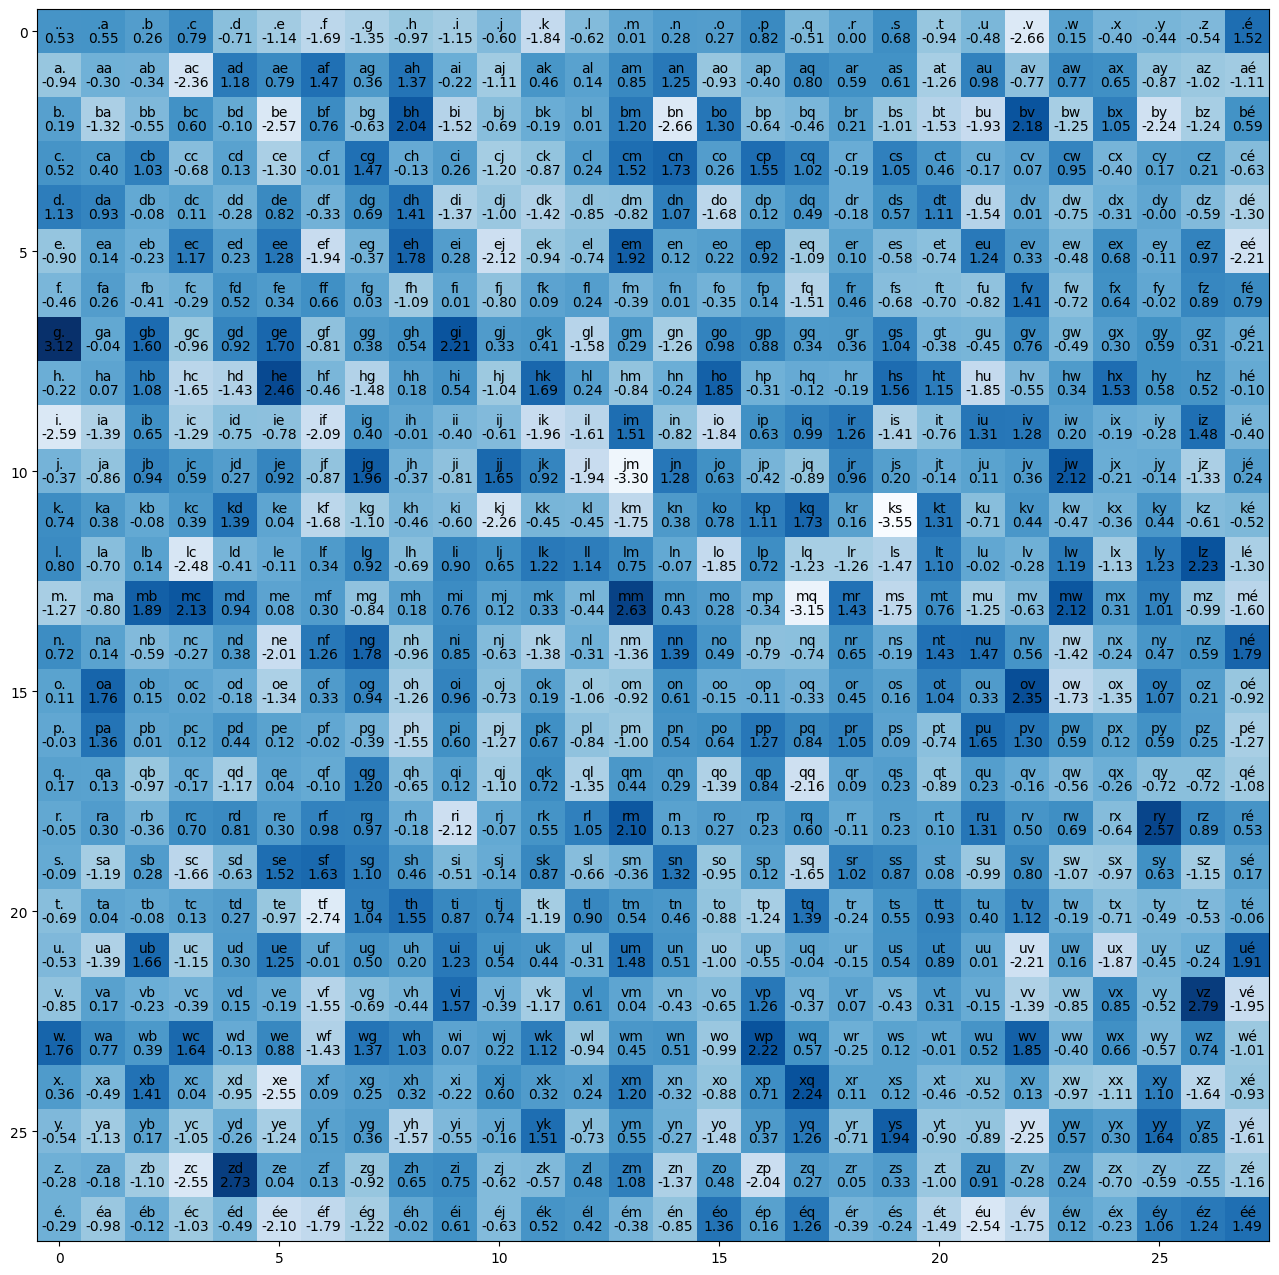

In [68]:
W2 = W.detach().numpy()
plt.figure(figsize=(16, 16))
plt.imshow(W2, cmap='Blues')
for i in range(num_letters):
    for j in range(num_letters):
        plt.text(j, i, f"{W2[i][j]:.2f}", va='top', ha='center')
        plt.text(j, i, f"{letters[i]}{letters[j]}", va='bottom', ha='center')

